<a href="https://colab.research.google.com/github/AdamW1002/CodeCloneDetectionCOMP599/blob/main/codebertsimilar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load required things and setup environment

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 15.3 MB/s 
     |████████████████████████████████| 596 kB 65.1 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 895 kB 69.2 MB/s 
     |████████████████████████████████| 6.5 MB 64.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import psutil 
import matplotlib.pyplot as plt


In [ ]:


MAX_TOKEN_DIM = 384 #controls padding and input to classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)
if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
  print("using cuda")
  
torch.cuda.device(device)
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert = AutoModel.from_pretrained("microsoft/codebert-base")

True
cuda
using cuda


In [ ]:
def load_data():
  f = open("/content/drive/MyDrive/CloneData/data.jsonl") #read sniipets and indices
  entries = f.readlines()
  objects = [json.loads(x) for x in entries] #load all functions
  idx_to_function = dict()
 
  for snippet in objects:#map to associate index to func
    
    idx_to_function[snippet["idx"]] = snippet["func"]

  return idx_to_function

In [ ]:
def pairify_file(lines : list, idx_to_function : dict) -> tuple:
  examples = []
  
  for line in lines:
    line_entries = line.replace("\t", " ").split(" ") #given line x y label, divide to find if x is y according to label
    #print(line)
    x = line_entries[0]
    y = line_entries[1]
    label = line_entries[2]
    
    examples.append((idx_to_function[x], idx_to_function[y], float(label))) #convert label to float for pytorch
  return examples


In [ ]:
def split_and_label_data(idx_to_function : dict): #convert pairs to useful training examples
  return tuple(map(  lambda x : pairify_file(open(x).readlines(), idx_to_function)  , ["/content/drive/MyDrive/CloneData/train.txt","/content/drive/MyDrive/CloneData/test.txt", "/content/drive/MyDrive/CloneData/valid.txt"]))


# Pre-calculate embeddings

In [ ]:
def embed(x : str) -> tuple:
  with torch.no_grad():
    code_tokens=tokenizer.tokenize(x)

    if len(code_tokens) >= 510: #confirm tokes arent too big for model
      return None
    tokens=[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]

    tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
    context_embeddings=codebert(torch.tensor(tokens_ids, device = device)[None,:])[0]
    
    flattened = torch.flatten(context_embeddings)
    print()
    
    
    return flattened #torch.clamp(flattened, min = -2, max = 2) #return flattened embedding vector

In [ ]:
def embed_data(data : list) -> list: #takes prog1, prog2, label and replaces prog with their embedding for every item in the list and filters out too long items
  embedded_data = []
  i = 0
  for x,y, label in data:
    print("using {} MB for {} of {}, embedded {}".format(psutil.Process().memory_info().rss / (1024 * 1024),i, len(data), len(embedded_data)))
    emb_x = embed(x)
    emb_y = embed(y)
   
    if emb_x != None and emb_y != None: #check code isnt too long
      x_embed = emb_x #Standardize embeddings lengths since they depend on #of tokens
      y_embed = emb_y
     
      padding_length_x  = (MAX_TOKEN_DIM * 768 - x_embed.size()[0])
      padding_length_y  = (MAX_TOKEN_DIM * 768 - y_embed.size()[0])
      
      x_padded = torch.nn.functional.pad(x_embed, (int(padding_length_x/2), int(padding_length_x/2)))
      y_padded = torch.nn.functional.pad(y_embed, (int(padding_length_y/2), int(padding_length_y/2)))
      embedded_data.append((x_padded,y_padded, label))
    i += 1
  return embedded_data 

In [ ]:
class CloneDataset(Dataset): #dataset 

  def __init__(self,x : list ,y : list,labels : list):
    assert len(x) == len(y) and len(y) == len(labels) #make sure all the same size
    #standard boilerplate
    self.x = (x)
    self.y = (y)
    self.labels = torch.tensor(labels)
    self.length = len(x)
    
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx], self.labels[idx]
  
  def __len__(self):
    return self.length

In [ ]:

#test_data = embed_data(test_data)
#validation_data = embed_data(validation_data)

In [ ]:
def build_dataset(data : list):
  x_list = []
  y_list = []
  label_list = []
  for x,y,l in data:#convert list of tuples to 3 separate lists
    #x.to(device)
    #y.to(device)

    x_list.append(torch.flatten(x))
    y_list.append(torch.flatten(y))
    label_list.append(l)

  return CloneDataset(x_list, y_list, label_list)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # Number of input features is 12.
        #self.layer_1 = nn.Linear(12, 64) 
        #self.layer_2 = nn.Linear(64, 64)
        #self.layer_out = nn.Linear(64, 1) 
        #
        #self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.1)
        #self.batchnorm1 = nn.BatchNorm1d(64)
        #self.batchnorm2 = nn.BatchNorm1d(64)
        
        #A note on architecture for those interested, we eat CodeBERT embeddings of size X  * 768 which have been flattened
        # Now those vectors are each fed into FF layer(s)
        #Then they're concatnated and fed thru more FF layer(s)
        # Then their dimensionality is shrunk down to 1, which is sigmoided
        layer2_size = 512
        layer3_size = 256
        layer4_size = 32
        self.xlayer_1 = nn.Linear(MAX_TOKEN_DIM * 768, layer2_size)
        self.ylayer_1 = nn.Linear(MAX_TOKEN_DIM * 768, layer2_size)

        self.ff1 = nn.Linear(2 * layer2_size, 1 )
        #self.ff2 = nn.Linear(layer3_size, 1)
        #self.ff3 = nn.Linear(layer4_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        nn.init.xavier_normal_(self.xlayer_1.weight)
        nn.init.xavier_normal_(self.ylayer_1.weight)
        nn.init.xavier_normal_(self.ff1.weight)
        #nn.init.xavier_normal_(self.ff2.weight)
        #nn.init.xavier_normal_(self.ff3.weight)

        #self.to(device)


    def forward(self, x,y):
       #x = self.relu(self.layer_1(inputs))
       #x = self.batchnorm1(x)
       #x = self.relu(self.layer_2(x))
       #x = self.batchnorm2(x)
       #x = self.dropout(x)
       #x = self.layer_out(x)
       #
       #return x
       xtemp = self.xlayer_1(x)
       xtemp = self.sigmoid(xtemp)

       ytemp = self.ylayer_1(y)
       ytemp = self.sigmoid(ytemp)

       
       combined = torch.cat((xtemp, ytemp),1)
      
       out = self.ff1(combined)
       #out = self.sigmoid(out)
       #out = self.ff2(out)
       #out = self.relu(out)
       #out = self.ff3(out)
       
       #out = self.sigmoid(out)
       return out


In [ ]:
idx_to_function = load_data()
train_data, test_data,validation_data = split_and_label_data(idx_to_function)
train_data = embed_data(train_data[:2000])
train_data = build_dataset(train_data)
trainLoader = DataLoader(train_data, batch_size= 100, shuffle = False)

# Train model

In [ ]:
def train():
  epochs  = 10 #standard boilerplate
  model = Classifier()
  print(model.ff1.weight.device)
  #criterion = nn.BCELoss()
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters())
  

  loss_history = []
  f1_history = []
  for epoch in range(epochs): #standard training procedure
    
    epoch_loss = 0
    
    tp_count = 0 #setup for f1 score
    fp_count = 0
    fn_count = 0
    f1 = 0
    
    j = 0
    for x,y, label in trainLoader:
      
      start = datetime.now()
      optimizer.zero_grad()
      print(x.dtype)
      print("max x {}".format(torch.max(x)))
     
      pred = model(x,y)
      pred.to("cpu")
      label.to("cpu")
      #print(pred)


      #print(label.shape)
      #print(pred.view(10).shape)
      loss = criterion(torch.flatten(pred.unsqueeze(1)),torch.flatten(label.unsqueeze(1)))
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2.0, norm_type = 2.0)
      optimizer.step()
      #print("pred is {}".format(pred))
      epoch_loss += loss.item()

      #calculate scores
      pred_rounded = torch.round(pred)
      for i in range(label.shape[0]):
        if pred_rounded[i] == 1 and label[i] == 1:
          tp_count += 1
        elif pred_rounded[i] == 1 and label[i] == 0:
          fp_count += 1
        elif pred_rounded[i] == 0 and label[i] == 1:
          fn_count += 1
      
      end = datetime.now()
      delta_t = end-start 

      
      if (tp_count + .5 * (fp_count + fn_count)) != 0: #dont get 0 for denom of f1
        f1 = tp_count/(tp_count + .5 * (fp_count + fn_count))
      if j % 10 == 0:
        print("time per iteration {} s".format(delta_t.microseconds / 10**6))
        print("at iteration{} of epoch {} total loss is {} , f1 is {}, tp is {}, current loss is {}".format(j,epoch,epoch_loss, f1, tp_count, loss.item()))
      j+=1
      loss_history.append(loss.item())
      f1_history.append(f1)

  return (loss_history,f1_history)

In [ ]:
loss_history, f1_history = train()

# Analzye results

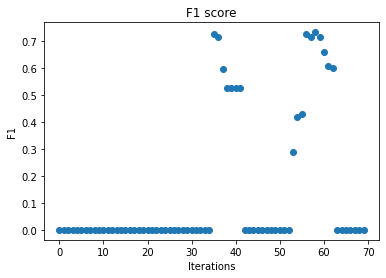

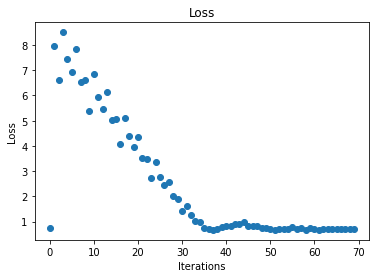

In [ ]:
plt.scatter(list(range(len(f1_history))), f1_history)
plt.title("F1 score")
plt.xlabel("Iterations")
plt.ylabel("F1")
plt.show()
plt.scatter(list(range(len(loss_history))), loss_history)
plt.title("Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()